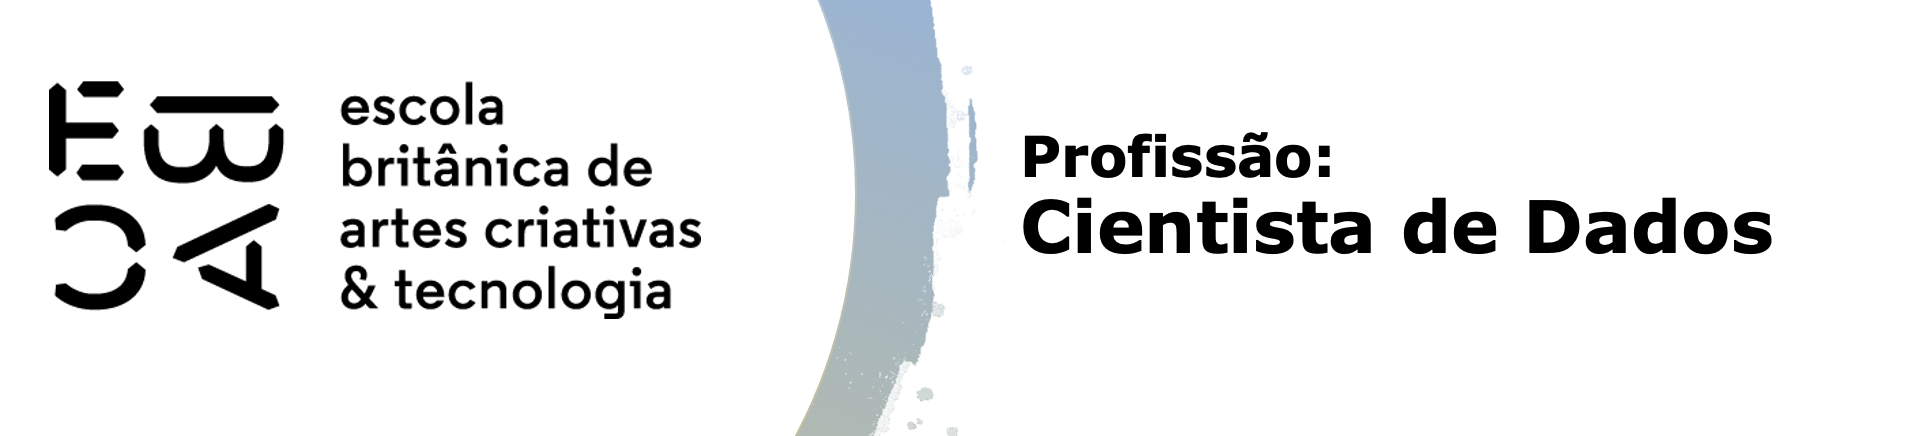

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [1]:
# Trabalho com os dados
import pandas as pd
import numpy as np
from joblib import load, dump

# Plot de figuras
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
# Importe dos dados
X_train = load("./data/X_train_df")
y_train = load("./data/y_train_df")
X_test = load("./data/X_test_df")
y_test = load("./data/y_test_df")

print(
        f"X_train: {np.array(X_train).shape}\n",
        f"y_train: {np.array(y_train).shape}\n",
        f"X_test: {np.array(X_test).shape}\n",
        f"y_test: {np.array(y_test).shape}\n",
)

X_train: (7352, 561)
 y_train: (7352,)
 X_test: (2210, 561)
 y_test: (2210,)



## Conclusão
- Dados importados.

---

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [3]:
# Instanciando os objetos com os algoritmos de árvores
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=123)

clf.fit(X_train, y_train)

# Verificando as métricas treino
mse2 = clf.score(X_test, y_test)

template = "O R² da árvore com profundidade "
template += f"{clf.get_depth()} é: {mse2:.2f}".replace(".",",")
print("Treinamento")
print(template)

Treinamento
O R² da árvore com profundidade 17 é: 0,74


In [4]:
# Instanciando uma DataFrame com a importância e o nome de cada variável
importances = pd.DataFrame(
    data={
        "importance": clf.feature_importances_,
        "columns": X_train.columns
        }
    )

# Ordenando as variáveis por importância para o modelo
importances_largest = importances[importances['importance'] != 0.0].sort_values(by="importance", ascending=False)
top_variaveis = importances_largest.head(3)['columns'].values
top_variaveis

array(['9 tBodyAcc-mad()-Z', '5 tBodyAcc-std()-Y',
       '86 tBodyAccJerk-std()-Z'], dtype=object)

In [5]:
# Verificando as três variáveis mais informativas do modelo
X_train_top = X_train[top_variaveis]
X_test_top = X_test[top_variaveis]

X_test_top.head()

,9 tBodyAcc-mad()-Z,5 tBodyAcc-std()-Y,86 tBodyAccJerk-std()-Z
204,-0.984758,-0.965636,-0.956380
41,-0.983663,-0.985671,0.617365
2809,-0.975246,-0.940278,0.020776
899,-0.091797,-0.471414,-0.148912
1225,-0.897576,-0.944146,-0.176078


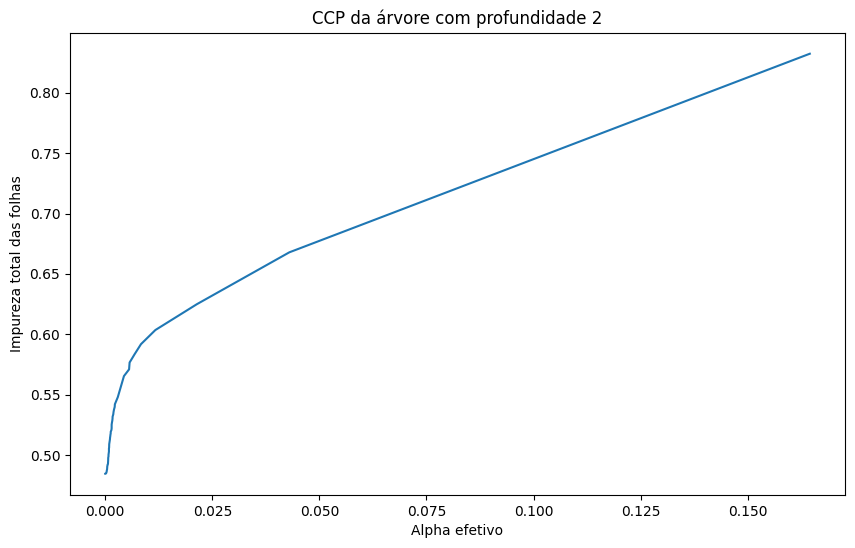

In [6]:
# Obtendo o caminho do CCP para árvore.
# Visualizando alphas e impurezas
# Instanciando os objetos com os algoritmos de árvores
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=123)

clf.fit(X_train_top, y_train)

path = clf.cost_complexity_pruning_path(X_test_top, y_test)
ccp_alphas_top, impurities_2 = path.ccp_alphas, path.impurities
ccp_alphas_top = np.unique(ccp_alphas_top[ccp_alphas_top >= 0])

plt.figure(figsize=(10, 6))
plt.title("CCP da árvore com profundidade 2")
plt.plot(ccp_alphas_top, impurities_2)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")
plt.show()

## Conclusão
- Lista com os ccp_alpha definidos nas três variáveis mais informativas;

---

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [7]:
def arvore(ccp_alphas_top: list, n_ccp: int = 10, cv: int = 10):
    # Definindo o modelo
    clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=123)
    
    # Definindo o número de ccp_alphas para análise
    ccp_alphas_top = ccp_alphas_top[::n_ccp]
    param_grid = {'ccp_alpha': ccp_alphas_top}

    # Executando a analise de variáveis
    grid = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        cv=cv,
        verbose=0
    )

    # Treinamento do modelo
    grid.fit(X_train_top, y_train)

    return grid


In [8]:
%%time
dados = {
    "ccp_alphas_top": ccp_alphas_top,
    "n_ccp": 5,
    "cv": 10
}
grid = arvore(**dados)
print(f"Acurácia: {grid.best_score_*100:.2f}%")

Acurácia: 53.63%
CPU times: total: 4.55 s
Wall time: 5.36 s


In [9]:
%%time
dados = {
    "ccp_alphas_top": ccp_alphas_top,
    "n_ccp": 15,
    "cv": 10
}
grid = arvore(**dados)
print(f"Acurácia: {grid.best_score_*100:.2f}%")

Acurácia: 53.41%
CPU times: total: 1.8 s
Wall time: 1.88 s


In [10]:
%%time
dados = {
    "ccp_alphas_top": ccp_alphas_top,
    "n_ccp": 5,
    "cv": 100
}
grid = arvore(**dados)
print(f"Acurácia: {grid.best_score_*100:.2f}%")

Acurácia: 56.21%
CPU times: total: 49.3 s
Wall time: 51.6 s


In [11]:
%%time
dados = {
    "ccp_alphas_top": ccp_alphas_top,
    "n_ccp": 5,
    "cv": 2
}
grid = arvore(**dados)
print(f"Acurácia: {grid.best_score_*100:.2f}%")

Acurácia: 53.06%
CPU times: total: 797 ms
Wall time: 837 ms


In [12]:
%%time
dados = {
    "ccp_alphas_top": ccp_alphas_top,
    "n_ccp": 10,
    "cv": 2
}
grid = arvore(**dados)
print(f"Acurácia: {grid.best_score_*100:.2f}%")

Acurácia: 53.06%
CPU times: total: 516 ms
Wall time: 516 ms


In [13]:
%%time
dados = {
    "ccp_alphas_top": ccp_alphas_top,
    "n_ccp": 10,
    "cv": 10
}
grid = arvore(**dados)
print(f"Acurácia: {grid.best_score_*100:.2f}%")


Acurácia: 53.58%
CPU times: total: 2.94 s
Wall time: 3.15 s


## Conclusão
- Observamos que existe pouca variação na acurácia, quando variamos o k e no número de ccp alphas analisados, quando observamos a melhor árvore, com apenas 3 variáveis mais inofmrativas;
- Porém, o tempo é significativamente alterado;

---

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [14]:
# Obtendo os resltados da melhor árvore e instânciando uma DataFrame
resultados = pd.DataFrame(grid.cv_results_)

# Obtendo o ccp alpha da melhor acurácia
melhor_ccp = resultados.iloc[grid.best_index_, 4]

# Instanciando uma nova árvore com as melhores métricas
clf_best = DecisionTreeClassifier(random_state=123, ccp_alpha=melhor_ccp)

# Treinando a árvore
clf_best.fit(X_train_top, y_train)

# Obtendo a acurácia no conjunto de test
print(f"Acurácia: {clf_best.score(X_test_top, y_test)*100:.2f}%")

Acurácia: 52.49%


## Conclusão
- A acurácia da árvore com nas melores condições de k-fold e CCP alpha foi de 52,49%

---

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```min_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [15]:
'''
Instanciando uma nova árvore, 
com melhor CCP alpha, profundidade 4 e mínimo de 20 amostras por folha
'''
clf_best = DecisionTreeClassifier(
    random_state=123,
    ccp_alpha=melhor_ccp,
    min_samples_leaf=20,
    max_depth=4
)

# Treinando a árvore com a base de treino contendo todas as variáveis
clf_best.fit(X_train, y_train)

# Anaisando acurácia
print(f"Acurácia: {clf_best.score(X_test, y_test)*100:.2f}%")

Acurácia: 62.49%


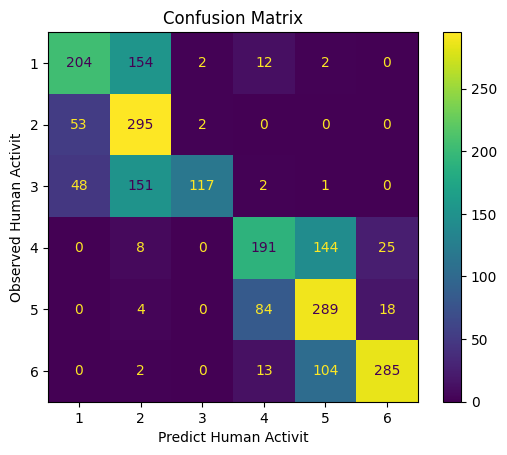

In [16]:
# Plotando a matriz de confusão
predictions = clf_best.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf_best.classes_,
)
disp.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predict Human Activit")
plt.ylabel("Observed Human Activit")
plt.show()


In [17]:
# Instanciando uma DataFrame com a importância e o nome de cada variável
importances = pd.DataFrame(
    data={
        "importance": clf_best.feature_importances_,
        "columns": X_train.columns
        }
    )

# Ordenando as variáveis por importância para o modelo
importances_largest = importances[importances['importance'] != 0.0].sort_values(by="importance", ascending=False)
top_variaveis = importances_largest.head(3)['columns'].values
top_variaveis

array(['9 tBodyAcc-mad()-Z', '5 tBodyAcc-std()-Y',
       '86 tBodyAccJerk-std()-Z'], dtype=object)

In [18]:
# Verificando as três variáveis mais informativas do modelo
X_train_top = X_train[top_variaveis]
X_test_top = X_test[top_variaveis]

X_test_top.head()

,9 tBodyAcc-mad()-Z,5 tBodyAcc-std()-Y,86 tBodyAccJerk-std()-Z
204,-0.984758,-0.965636,-0.956380
41,-0.983663,-0.985671,0.617365
2809,-0.975246,-0.940278,0.020776
899,-0.091797,-0.471414,-0.148912
1225,-0.897576,-0.944146,-0.176078


In [19]:
'''
Instanciando uma nova árvore, 
com melhor CCP alpha, profundidade 4 e mínimo de 20 amostras por folha
'''
clf_best = DecisionTreeClassifier(
    random_state=123,
    ccp_alpha=melhor_ccp,
    min_samples_leaf=20,
    max_depth=4
)

# Treinando a árvore com a base de treino contendo todas as variáveis
clf_best.fit(X_train_top, y_train)

# Anaisando acurácia
print(f"Acurácia: {clf_best.score(X_test_top, y_test)*100:.2f}%")

Acurácia: 48.51%


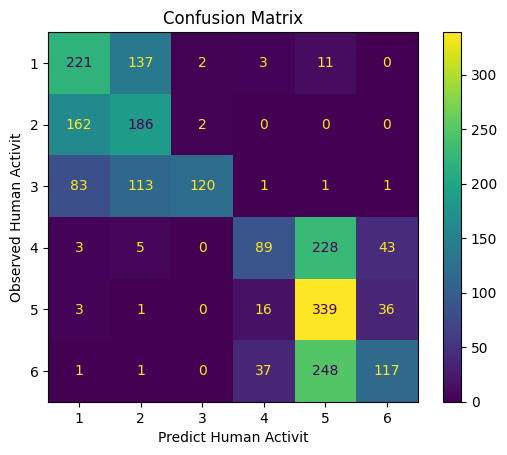

In [20]:
# Plotando a matriz de confusão
predictions = clf_best.predict(X_test_top)
cm = confusion_matrix(y_test, predictions, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf_best.classes_,
)
disp.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predict Human Activit")
plt.ylabel("Observed Human Activit")
plt.show()


## Conclusão
- Quando usado o conjunto completo, com todas as varíaveis explicativas, temos uma melhor acurácia, 62,49%.
- Já usando apenas as três variáveis com maior poder explicativo, a curácia é reduzida para 48,51%.
- As variáveis 1, 2 e 3 apresentam menos Falsos Negativos em relação a 4, 5 e 5;
- Já as variáveis 4, 5 e 6 apresentam menos Falsos Positivos em relação a 1, 2 e 3;